Creditworthiness Prediction for Credit Card Issuance

You have been hired by Pro National Bank as a data scientist, and your first task is to develop a model capable of estimating the creditworthiness of clients to help the dedicated team decide whether to approve or deny a credit card application.

To this end, you are provided with anonymized data of clients who have already obtained a credit card and regularly pay their installments.

The data is in a CSV file available at this address: https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv

The file credit_scoring.csv contains information about account holders who have requested a credit line.

ID: customer identification number
CODE_GENDER: gender of the client
FLAG_OWN_CAR: indicator of car ownership
FLAG_OWN_REALTY: indicator of home ownership
CNT_CHILDREN: number of children
AMT_INCOME_TOTAL: annual income
NAME_INCOME_TYPE: type of income
NAME_EDUCATION_TYPE: level of education
NAME_FAMILY_STATUS: marital status
NAME_HOUSING_TYPE:
DAYS_BIRTH: number of days since birth
DAYS_EMPLOYED: number of days since employment, if positive indicates the number of days since unemployment
FLAG_MOBIL: indicator of the presence of a mobile phone number
FLAG_WORK_PHONE: indicator of the presence of a work phone number
FLAG_PHONE: indicator of the presence of a phone number
FLAG_EMAIL: indicator of the presence of an email address
OCCUPATION_TYPE: type of occupation
CNT_FAM_MEMBERS: number of family members
TARGET: a variable that equals 1 if the client has high credit reliability due to consistent payment of installments, and 0 otherwise.
You need to develop a model that predicts the given target.

BONUS POINT

If a client is denied a credit card, the team must be able to provide a reason. This means that your model must provide easily interpretable indications.


# Workflow

Acquisition and Constants: 1.1 Libraries and modules 1.2 Data 1.3 Declaration of constants

Data Preprocessing: 2.1 Preliminary exploration with descriptive statistics 2.2 Check balance of the target variable and any missing values 2.3 Encoding 2.4 Verify database completeness and potential removal/imputation 2.5 Scaling 2.6 Feature selection: Split into train set and test set considering any imbalances 2.7 Feature selection: Check correlation and distribution of features 2.8 Model: Split into train set and test set considering any imbalances

Creation of Baseline Model and Its Improvement: 3.1 Logistic regression, useful for providing easily interpretable insights 3.2 Model improvements 3.3 Verification of model parameters 3.4 Additional point


# 1) Aquisition and Constants

## 1.1 libraries and modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import shapiro, kstest, norm, normaltest, probplot, anderson, yeojohnson
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## 1.2 data

In [2]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv

--2024-06-28 13:38:03--  https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 3.5.224.142, 16.12.18.6
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|3.5.224.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46681024 (45M) [text/csv]
Saving to: ‘credit_scoring.csv.16’

credit_scoring.csv. 100%[===================>]  44,52M   286KB/s    in 1m 48s  

2024-06-28 13:39:56 (422 KB/s) - ‘credit_scoring.csv.16’ saved [46681024/46681024]



## 1.3 Declaration of constants

In [3]:
RANDOM_SEED = 0

# 2) Data Preprocessing

## 2.1 Preliminary exploration through descriptive statistics

In [4]:
df = pd.read_csv("credit_scoring.csv")
df.head()


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1


In [ ]:
# 'ID' feature must be dropped, but first let's check his levels to verify no information will be lost 

feature_name = 'ID'
duplicates_presence = df[df.duplicated(subset=[feature_name], keep=False)]

if duplicates_presence.empty:
    print("No repetitions.")
else:
    print("Repetitions found")

Tutti i nomi nella feature sono unici. Non ci sono ripetizioni.


In [ ]:
# every observation is unique, we may proceed with 'ID' drop

df = df.drop("ID", axis=1)

In [7]:
print(df.describe())

        CNT_CHILDREN  AMT_INCOME_TOTAL     DAYS_BIRTH  DAYS_EMPLOYED  \
count  338427.000000      3.384270e+05  338426.000000  338426.000000   
mean        0.428934      1.876543e+05  -15998.249644   60238.497163   
std         0.727990      1.106747e+05    4180.240053  138499.153147   
min         0.000000      2.610000e+04  -25201.000000  -17531.000000   
25%         0.000000      1.215000e+05  -19482.000000   -3116.000000   
50%         0.000000      1.620000e+05  -15622.000000   -1485.000000   
75%         1.000000      2.250000e+05  -12524.000000    -380.000000   
max        19.000000      6.750000e+06   -7489.000000  365243.000000   

       FLAG_MOBIL  FLAG_WORK_PHONE     FLAG_PHONE     FLAG_EMAIL  \
count    338426.0    338426.000000  338426.000000  338426.000000   
mean          1.0         0.211379       0.293302       0.105181   
std           0.0         0.408287       0.455276       0.306787   
min           1.0         0.000000       0.000000       0.000000   
25%        

Preliminary descriptive statistics provide initial information about the distribution of the TARGET, with the mean being heavily skewed towards 0, indicating an expected imbalance. We also note the presence of values with very different scales, which will require scaling. The absence of some features suggests a categorical nature, making preliminary encoding appropriate. Notably, the 'NAME_EDUCATION_TYPE' class, if it were more aligned with Anglo-Saxon educational levels, could have been treated as ordinal categorical and thus managed with Label Encoding instead of One-Hot Encoding (OHE).

In [ ]:
# since a standardization is on schedule let's check which are the continuous numerical features 
num_features = df.select_dtypes(include=['int64', 'float64'])

# looking at the features, CNT_CHILDREN is the only one with possible values above 1, 
# therefore we set as a precautious threshold value a presence of unique values over 20 to identify continuous numerical features
def is_continuous(feature):
    unique_values = feature.nunique()
    total_values = len(feature)
    return unique_values > 20

# filters unique values
continuous_features = num_features.loc[:, num_features.apply(is_continuous)]

# visualize continue columns
print("Continuous numerical features to standardize:")
print(continuous_features.columns)

Feature numeriche continue su cui verrà operata standardizzazione:
Index(['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED'], dtype='object')


## 2.2 check target balancing and missing values

In [ ]:
# check target balancing

distri_target = df['TARGET'].value_counts()
print(distri_target)
print(f"Ratio: {distri_target[0]/distri_target[1]:.0f}:1")

0    308705
1     29722
Name: TARGET, dtype: int64
Ratio: 10:1


The distribution of the target variable is highly imbalanced with a 10:1 ratio. Therefore, this must be appropriately considered in subsequent phases, for example, by applying a correction in the train and test set division using the 'stratify' argument in the train_test_split command.

In [ ]:
# check for missing values

missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0]

if missing_columns.empty:
    print("Non ci sono valori mancanti nel dataset.")
else:
    print("Ci sono valori mancanti nelle seguenti colonne:")
    print(missing_columns)

Ci sono valori mancanti nelle seguenti colonne:
NAME_FAMILY_STATUS         1
NAME_HOUSING_TYPE          1
DAYS_BIRTH                 1
DAYS_EMPLOYED              1
FLAG_MOBIL                 1
FLAG_WORK_PHONE            1
FLAG_PHONE                 1
FLAG_EMAIL                 1
OCCUPATION_TYPE       103342
CNT_FAM_MEMBERS            1
dtype: int64


In [ ]:
# verify which are the observations with missing values 

columns_with_missing = ['NAME_FAMILY_STATUS',
                        'NAME_HOUSING_TYPE',
                        'DAYS_BIRTH',
                        'DAYS_EMPLOYED',
                        'FLAG_MOBIL',
                        'FLAG_WORK_PHONE',
                        'FLAG_PHONE',
                        'FLAG_EMAIL',
                        'CNT_FAM_MEMBERS'                        
                        ]

for i in columns_with_missing:
    missing_observations = df[df[i].isnull()]  
    print(f"Missing values in column '{i}':")
    print(missing_observations)

Osservazioni mancanti nella colonna 'NAME_FAMILY_STATUS':
       CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
338426           F            N               N             0   

        AMT_INCOME_TOTAL NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
338426           67500.0          Working      Secondary / se   

       NAME_FAMILY_STATUS NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
338426                NaN               NaN         NaN            NaN   

        FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
338426         NaN              NaN         NaN         NaN             NaN   

        CNT_FAM_MEMBERS  TARGET  
338426              NaN       0  
Osservazioni mancanti nella colonna 'NAME_HOUSING_TYPE':
       CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
338426           F            N               N             0   

        AMT_INCOME_TOTAL NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
338426           67500.0          Working      Seco

In [ ]:
# looking at the analysis, only one row number 338426 shows missing values, verify

print(df.tail())

       CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
338422           F            N               Y             0   
338423           F            N               Y             0   
338424           F            N               Y             0   
338425           F            N               Y             0   
338426           F            N               N             0   

        AMT_INCOME_TOTAL NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
338422          157500.0        Pensioner  Secondary / secondary special   
338423          157500.0        Pensioner  Secondary / secondary special   
338424          157500.0        Pensioner  Secondary / secondary special   
338425          157500.0        Pensioner  Secondary / secondary special   
338426           67500.0          Working                 Secondary / se   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
338422            Married  House / apartment    -23661.0       365243.0   
33

In [ ]:
# being a considerably huge dataset, let's proceed to remove the single observation without too much of a concern 
# paying attention to exlude the feature 'OCCUPATION_TYPE' which clearly would lead to 103342 observation removal if the argument would remain as default

df = df.dropna(subset=['NAME_FAMILY_STATUS',
                        'NAME_HOUSING_TYPE',
                        'DAYS_BIRTH',
                        'DAYS_EMPLOYED',
                        'FLAG_MOBIL',
                        'FLAG_WORK_PHONE',
                        'FLAG_PHONE',
                        'FLAG_EMAIL',
                        'CNT_FAM_MEMBERS' ])

In [ ]:
# verify the absence of missing observations of the features to explore 
# and that the observation with missing values has been effectively removed 

for i in columns_with_missing:
    missing_observations = df[df[i].isnull()]
    if not missing_observations.empty:
        print(f"Osservazioni mancanti nella colonna '{i}':")
        print(missing_observations)

# PROBLEMATIC FEATURE 'OCCUPATION_TYPE' MANAGEMENT

After removing observations with missing values, a separate discussion is warranted for the 'OCCUPATION_TYPE' feature. This feature shows a significant number of missing values, but since it relates to the type of employment and therefore indirectly to the subjects' income, it likely contains relevant information, making it unwise to eliminate it. Therefore, the missing values should be imputed. Normally, one solution might be KNN, but given the large size of the dataset and the high computational demands of KNN, after initially testing it, we opt for the lighter Iterative Imputer.

To proceed with imputation, all features must be numerical, so it will be necessary to first perform One-Hot Encoding (OHE). The order of operations will therefore be: One-Hot Encoding for features other than 'TARGET' and 'OCCUPATION_TYPE', then temporary encoding using Ordinal Encoding for 'OCCUPATION_TYPE', Iterative Imputation, final One-Hot Encoding on 'OCCUPATION_TYPE', checks on the distribution of numerical features for potential transformations, and standardization prior to model application.

In [16]:
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,0
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,0
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1


In [ ]:
# let's separate categorical features from numericals and from the ones target of the Iterative imputation

categorical_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']
categorical_feature_to_impute = ['OCCUPATION_TYPE']
numerical_features = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'TARGET']

# let's create a df variable witn categorical features only

categorical_df = df[categorical_features]


## 2.3 encoding

In [ ]:
# intervene on 'categorical_df'
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_features = encoder.fit_transform(categorical_df).toarray()

# ricompose the df adding to the post encoding feature 'encoded_features', the other features, i.e. 'OCCUPATION_TYPE' and the numerical
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
df = pd.concat([encoded_df, df[['OCCUPATION_TYPE', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'TARGET']]], axis=1)

# check that everything is in order through 'OCCUPATION_TYPE' that we will address in the next step
df.head()

,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,...,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,TARGET
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,427500.0,-12005.0,-4542.0,1.0,1.0,0.0,0.0,2.0,0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,427500.0,-12005.0,-4542.0,1.0,1.0,0.0,0.0,2.0,0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,112500.0,-21474.0,-1134.0,1.0,0.0,0.0,0.0,2.0,0
3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,270000.0,-19110.0,-3051.0,1.0,0.0,1.0,1.0,1.0,1
4,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,270000.0,-19110.0,-3051.0,1.0,0.0,1.0,1.0,1.0,1


In [ ]:
# check that 'OCCUPATION_TYPE' is intact

print(df['OCCUPATION_TYPE'].head())

0               NaN
1               NaN
2    Security staff
3       Sales staff
4       Sales staff
Name: OCCUPATION_TYPE, dtype: object


## 2.4 check database integruty and possible removal/imputation
This step is slightly complex. We know that the dataset has now had the observation with missing values removed, so currently, the only missing values are all contained in the 'OCCUPATION_TYPE' feature. To proceed with its imputation, two conditions must be met: 1) the other categorical features must have been adequately transformed using One-Hot Encoding (OHE), which has been done, 2) 'OCCUPATION_TYPE' must have a temporary numerical assignment through Ordinal encoding of the present values, in order to then impute the missing ones, and finally apply an additional One-Hot Encoding to ensure that the categories are correctly handled in logistic regression.

In [ ]:
# apply ordinal encoding on 'OCCUPATION_TYPE'
ordinal_encoder = OrdinalEncoder()
df['OCCUPATION_TYPE'] = ordinal_encoder.fit_transform(df[['OCCUPATION_TYPE']])

# apply imputation
# Inizialize and apply fit_transform
iterative_imputer = IterativeImputer(max_iter=10, random_state=RANDOM_SEED)
df['OCCUPATION_TYPE'] = iterative_imputer.fit_transform(df[['OCCUPATION_TYPE']])

# verify correct imputation of 'OCCUPATION_TYPE' through null values research
print(df['OCCUPATION_TYPE'].isnull().sum())

0


In [ ]:
# One hot encoding
one_hot_encoded_occupation_type = pd.get_dummies(df['OCCUPATION_TYPE'], prefix='OCCUPATION_TYPE')

df = pd.concat([df, one_hot_encoded_occupation_type], axis=1)
df.drop('OCCUPATION_TYPE', axis=1, inplace=True)

print(df.head())

   CODE_GENDER_F  CODE_GENDER_M  FLAG_OWN_CAR_N  FLAG_OWN_CAR_Y  \
0            0.0            1.0             0.0             1.0   
1            0.0            1.0             0.0             1.0   
2            0.0            1.0             0.0             1.0   
3            1.0            0.0             1.0             0.0   
4            1.0            0.0             1.0             0.0   

   FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  \
0                0.0                1.0   
1                0.0                1.0   
2                0.0                1.0   
3                0.0                1.0   
4                0.0                1.0   

   NAME_INCOME_TYPE_Commercial associate  NAME_INCOME_TYPE_Pensioner  \
0                                    0.0                         0.0   
1                                    0.0                         0.0   
2                                    0.0                         0.0   
3                                    1.0          

In [ ]:
print(df.columns)

Index(['CODE_GENDER_F', 'CODE_GENDER_M', 'FLAG_OWN_CAR_N', 'FLAG_OWN_CAR_Y',
       'FLAG_OWN_REALTY_N', 'FLAG_OWN_REALTY_Y',
       'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married',
       'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_Co-op apartment',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',

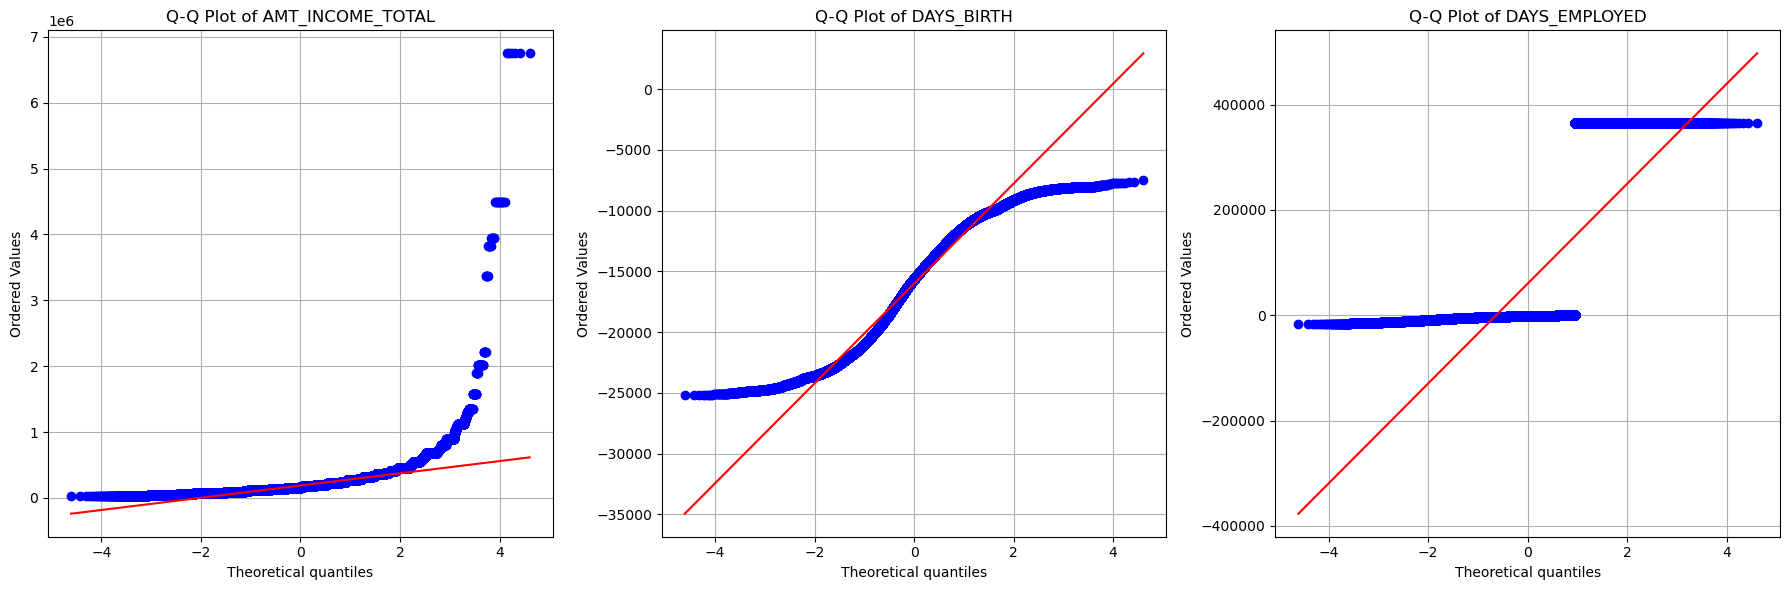

In [ ]:
# observe the distribution of the 3 numerical features in 'continuous_features' 
# in order to operate preliminar transformations before standardization

# Q-Q plot

# create and visualize Q-Q plot beside each other
def plot_qq_side_by_side(df, continuous_features):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, feature_name in enumerate(continuous_features):
        feature = df[feature_name]
        probplot(feature, dist="norm", plot=axes[i])
        axes[i].set_title(f'Q-Q Plot of {feature_name}')
        axes[i].grid()
    
    plt.tight_layout()
    plt.show()

plot_qq_side_by_side(df, continuous_features)

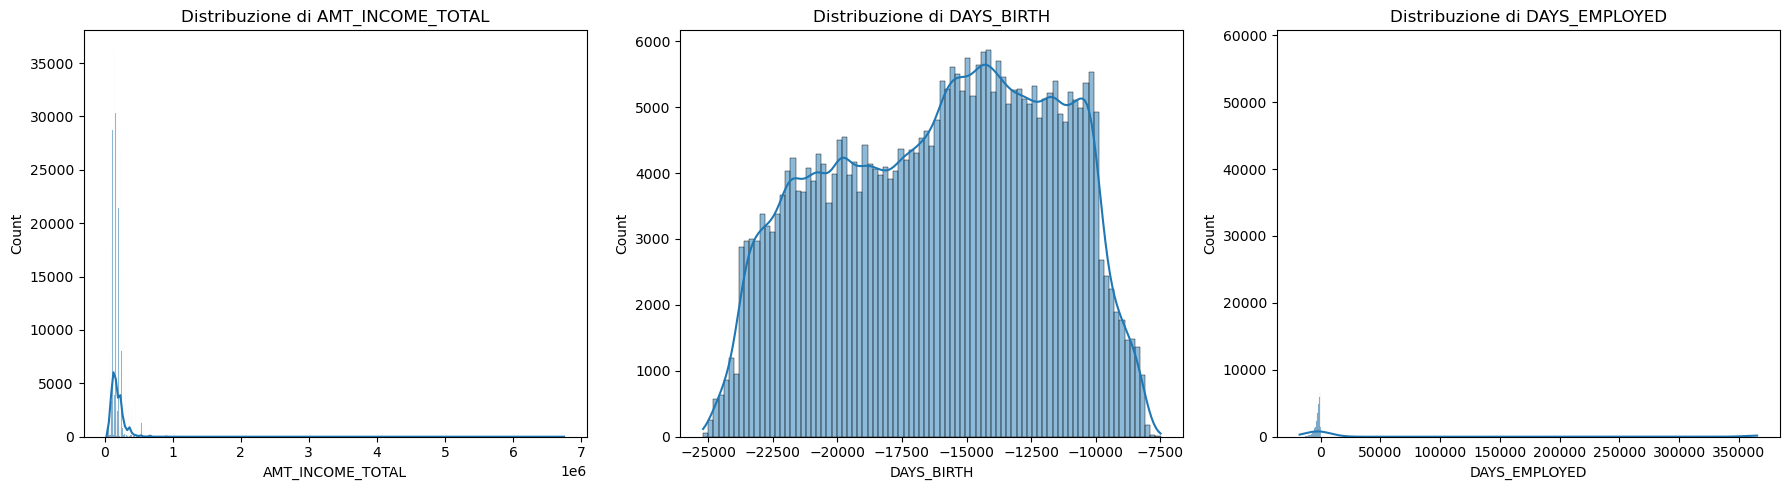

In [ ]:
# bar plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(continuous_features):
    sns.histplot(df[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribuzione di {feature}')

plt.tight_layout()
plt.show()

In [ ]:
# we observe significant distributions that justify a deeper investigation through statistical testing
# normally Shapiro and Kolmogorov tests are used, but on large samples like this one, they will likely yield highly significant results

def test_normality(feature):
    shapiro_stat, shapiro_p = shapiro(feature)
    ks_stat, ks_p = kstest(feature, 'norm', args=(feature.mean(), feature.std()))
    
    print(f"Shapiro-Wilk Test per {feature.name}:")
    print(f"Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.4f}")
    print(f"Kolmogorov-Smirnov Test per {feature.name}:")
    print(f"Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")
    print("\n")

for feature_name in continuous_features:
    print(f"Testing feature: {feature_name}")
    test_normality(df[feature_name])

Testing feature: AMT_INCOME_TOTAL
Shapiro-Wilk Test per AMT_INCOME_TOTAL:
Statistic: 0.7036, p-value: 0.0000
Kolmogorov-Smirnov Test per AMT_INCOME_TOTAL:
Statistic: 0.1560, p-value: 0.0000


Testing feature: DAYS_BIRTH
Shapiro-Wilk Test per DAYS_BIRTH:
Statistic: 0.9676, p-value: 0.0000
Kolmogorov-Smirnov Test per DAYS_BIRTH:
Statistic: 0.0511, p-value: 0.0000


Testing feature: DAYS_EMPLOYED
Shapiro-Wilk Test per DAYS_EMPLOYED:
Statistic: 0.4695, p-value: 0.0000
Kolmogorov-Smirnov Test per DAYS_EMPLOYED:
Statistic: 0.4973, p-value: 0.0000




/home/marco/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
# the tests confirm in all 3 cases that the distribution is NOT normal, with very significant p-values,
# before proceeding with the transformations, we also verify with D'Agostino's K-squared, which is more suitable for large sets

def test_normality_dago(feature):
    # D'Agostino's K-squared Test
    k2_stat, k2_p = normaltest(feature)
    print(f"D'Agostino's K-squared Test:")
    print(f"Statistic: {k2_stat:.4f}, p-value: {k2_p:.4f}")

for feature_name in continuous_features:
    print(f"Testing feature: {feature_name}")
    test_normality_dago(df[feature_name])


Testing feature: AMT_INCOME_TOTAL
D'Agostino's K-squared Test:
Statistic: 533073.0652, p-value: 0.0000
Testing feature: DAYS_BIRTH
D'Agostino's K-squared Test:
Statistic: 101451.2102, p-value: 0.0000
Testing feature: DAYS_EMPLOYED
D'Agostino's K-squared Test:
Statistic: 92176.5094, p-value: 0.0000


anche D'Agostino conferma la NON normalità, quindi passiamo alle trasformazioni, in questo caso potrebbe essere apppropriata una trasformazione di Yeo-Johnson

Original feature: AMT_INCOME_TOTAL
Shapiro-Wilk Test per AMT_INCOME_TOTAL:
Statistic: 0.7036, p-value: 0.0000
Kolmogorov-Smirnov Test per AMT_INCOME_TOTAL:
Statistic: 0.1560, p-value: 0.0000




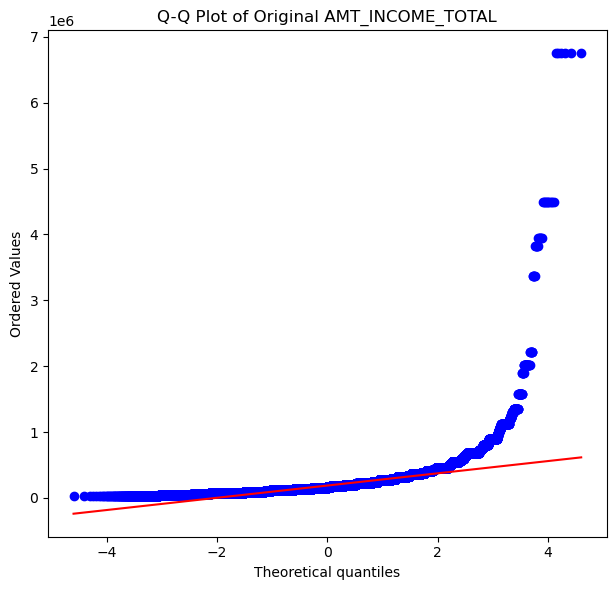

Yeo-Johnson transformed feature: AMT_INCOME_TOTAL
Shapiro-Wilk Test per Yeo-Johnson transformed AMT_INCOME_TOTAL:
Statistic: 0.9921, p-value: 0.0000
Kolmogorov-Smirnov Test per Yeo-Johnson transformed AMT_INCOME_TOTAL:
Statistic: 0.0563, p-value: 0.0000




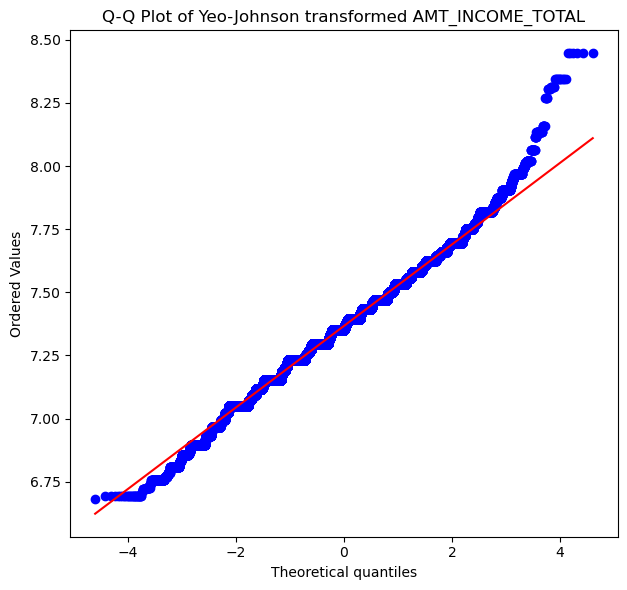

Original feature: DAYS_BIRTH
Shapiro-Wilk Test per DAYS_BIRTH:
Statistic: 0.9676, p-value: 0.0000
Kolmogorov-Smirnov Test per DAYS_BIRTH:
Statistic: 0.0511, p-value: 0.0000




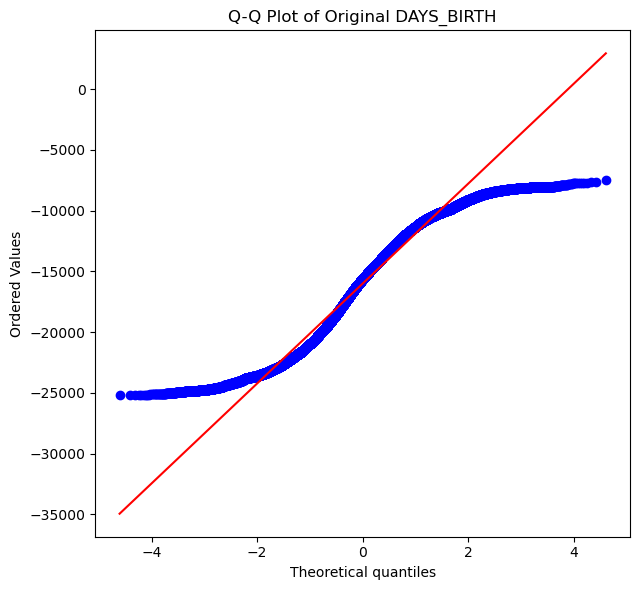

Yeo-Johnson transformed feature: DAYS_BIRTH
Shapiro-Wilk Test per Yeo-Johnson transformed DAYS_BIRTH:
Statistic: 0.9721, p-value: 0.0000
Kolmogorov-Smirnov Test per Yeo-Johnson transformed DAYS_BIRTH:
Statistic: 0.0538, p-value: 0.0000




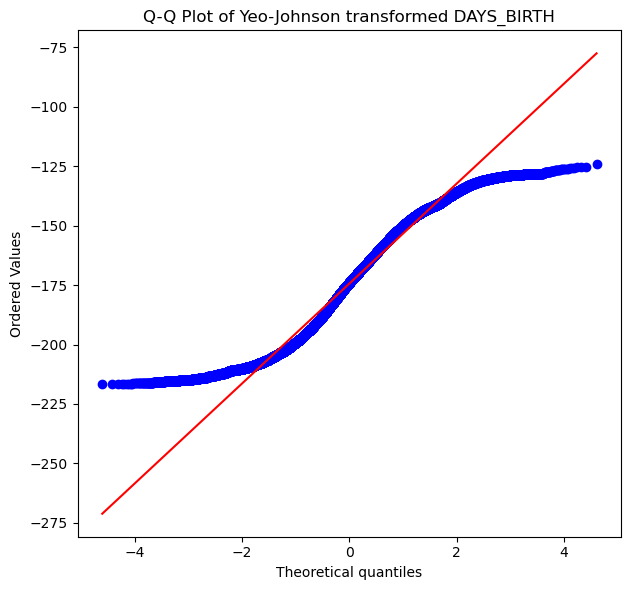

Original feature: DAYS_EMPLOYED
Shapiro-Wilk Test per DAYS_EMPLOYED:
Statistic: 0.4695, p-value: 0.0000
Kolmogorov-Smirnov Test per DAYS_EMPLOYED:
Statistic: 0.4973, p-value: 0.0000




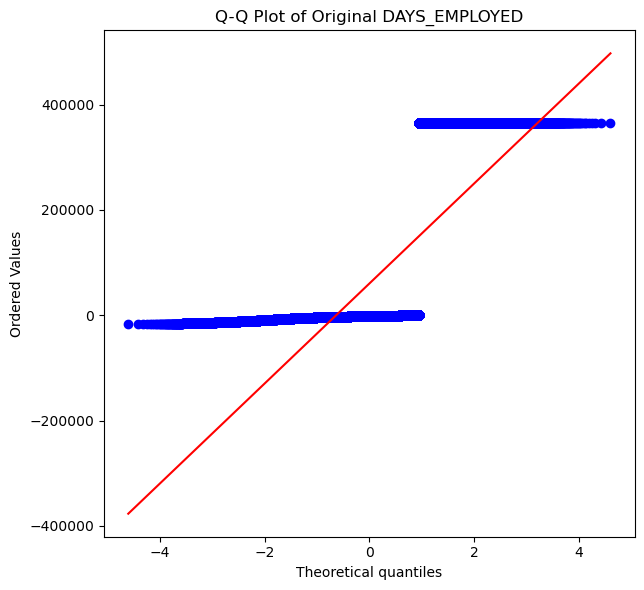

Yeo-Johnson transformed feature: DAYS_EMPLOYED
Shapiro-Wilk Test per Yeo-Johnson transformed DAYS_EMPLOYED:
Statistic: 0.8813, p-value: 0.0000
Kolmogorov-Smirnov Test per Yeo-Johnson transformed DAYS_EMPLOYED:
Statistic: 0.1530, p-value: 0.0000




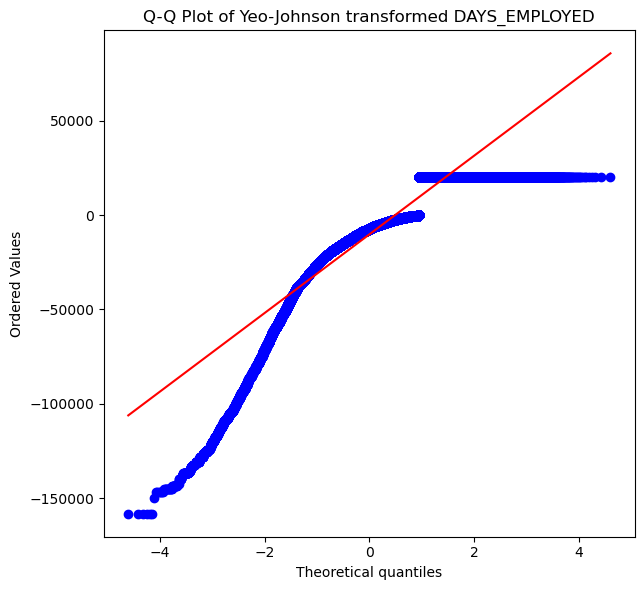

In [ ]:

def plot_distribution(feature, title):
    plt.figure(figsize=(12, 6))

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    probplot(feature, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {title}')

    plt.tight_layout()
    plt.show()

def test_normality(feature, feature_name):
    shapiro_stat, shapiro_p = shapiro(feature)
    ks_stat, ks_p = kstest(feature, 'norm', args=(feature.mean(), feature.std()))

    print(f"Shapiro-Wilk Test per {feature_name}:")
    print(f"Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.4f}")
    print(f"Kolmogorov-Smirnov Test per {feature_name}:")
    print(f"Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")
    print("\n")


def transform_and_test(feature, feature_name):
    print(f"Original feature: {feature_name}")
    test_normality(feature, feature_name)
    plot_distribution(feature, f"Original {feature_name}")

    yeojohnson_transformed, _ = yeojohnson(feature)
    print(f"Yeo-Johnson transformed feature: {feature_name}")
    test_normality(yeojohnson_transformed, f"Yeo-Johnson transformed {feature_name}")
    plot_distribution(yeojohnson_transformed, f"Yeo-Johnson transformed {feature_name}")

for feature_name in continuous_features:
    feature = df[feature_name]
    transform_and_test(feature, feature_name)

## 2.5 scaling

In [ ]:
print(df.dtypes.value_counts())

float64    35
uint8      19
int64       2
dtype: int64


In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(continuous_features)

In [ ]:
# numpy array in pandas dataframe conversion 
scaled_df = pd.DataFrame(scaled_features, columns=continuous_features.columns, index=continuous_features.index)

df[continuous_features.columns] = scaled_df

In [31]:
continuous_features.columns

Index(['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED'], dtype='object')

In [32]:
print(df[['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED']].head())

   AMT_INCOME_TOTAL  DAYS_BIRTH  DAYS_EMPLOYED
0          2.167126    0.955269      -0.467733
1          2.167126    0.955269      -0.467733
2         -0.679057   -1.309915      -0.443126
3          0.744034   -0.744396      -0.456967
4          0.744034   -0.744396      -0.456967


## 2.6 feature selection: train/test set division keeping in mind possible unbalancing
We observed in section 2.2 that the imbalance in the 'TARGET' feature is very strong, with a 10:1 ratio. Therefore, in the train-test split, we will add the 'stratify' argument to the train_test_split command.

In [ ]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_SEED)

In [ ]:
y_check = pd.Series(y)
y_train_check = pd.Series(y_train)
y_test_check = pd.Series(y_test)
print("Class Ratio - Original TARGET")
print(y_check.value_counts(normalize=True))
print("Class Ratio - Train")
print(y_train_check.value_counts(normalize=True))
print("Class Ratio - Test")
print(y_test_check.value_counts(normalize=True))

Class Ratio - Original TARGET
0    0.912176
1    0.087824
Name: TARGET, dtype: float64
Class Ratio - Train
0    0.912177
1    0.087823
Name: TARGET, dtype: float64
Class Ratio - Test
0    0.912172
1    0.087828
Name: TARGET, dtype: float64


## 2.7 feature selection: verifying the correlation and feature distributio

Having a dataset with many categorical features that necessarily required One-Hot encoding and not Label encoding due to the non-ordinality of the levels, to prepare a correlation matrix, it is first necessary to trim the numerous features generated by the OHE processes. To do this, it is possible to use:

1) a Random Forest model, compute the top - for example - 20 features in a correlation matrix, and then remove those that are correlated, repeating the check with the updated list of the new top 20, and so on.

2) or directly visualize the list of all correlations, eliminate the features that are strongly correlated, and then produce the correlation matrix.

This second approach seems more rational. For exercise purposes, the solution is provided below through both.

### A) Random Forest

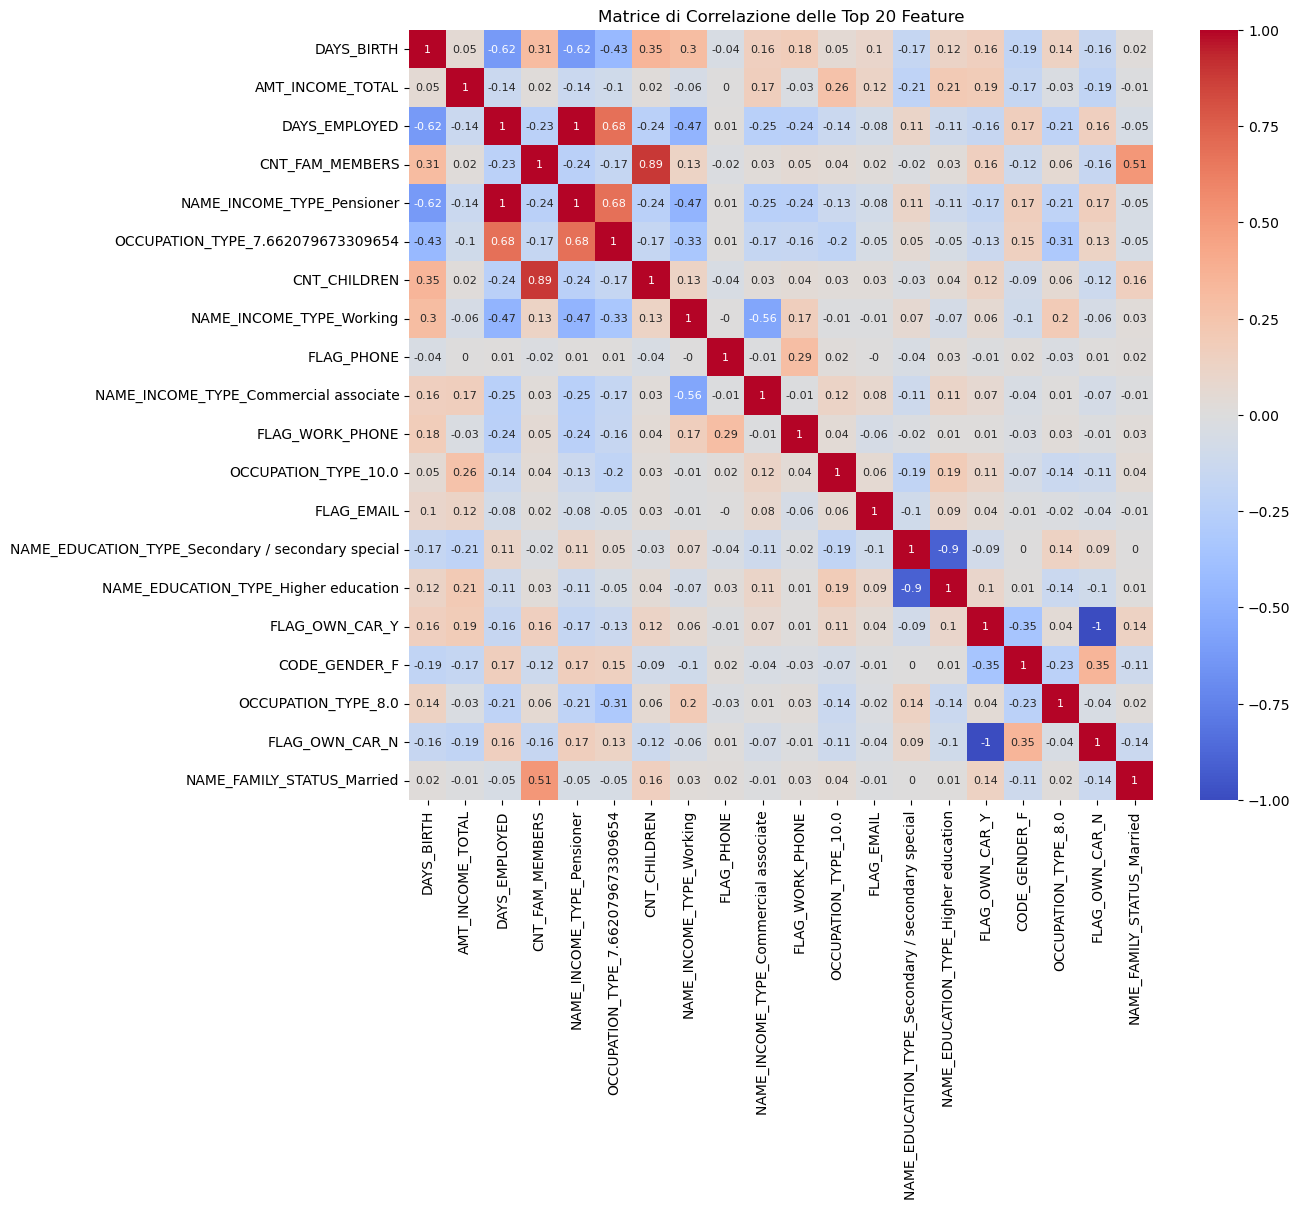

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Feature importance
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)

# selecting 20 best features
top_features = feature_importances.nlargest(20).index 

# correlation matrix on top 20 features
correlation_matrix = df[top_features].corr()
correlation_matrix_rounded = correlation_matrix.round(2)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_rounded, annot=True, cmap='coolwarm', annot_kws={"size": 8})
plt.title('Matrice di Correlazione delle Top 20 Feature')
plt.show()

### B) feature list and elimination of feature couples with correlation above 0.8

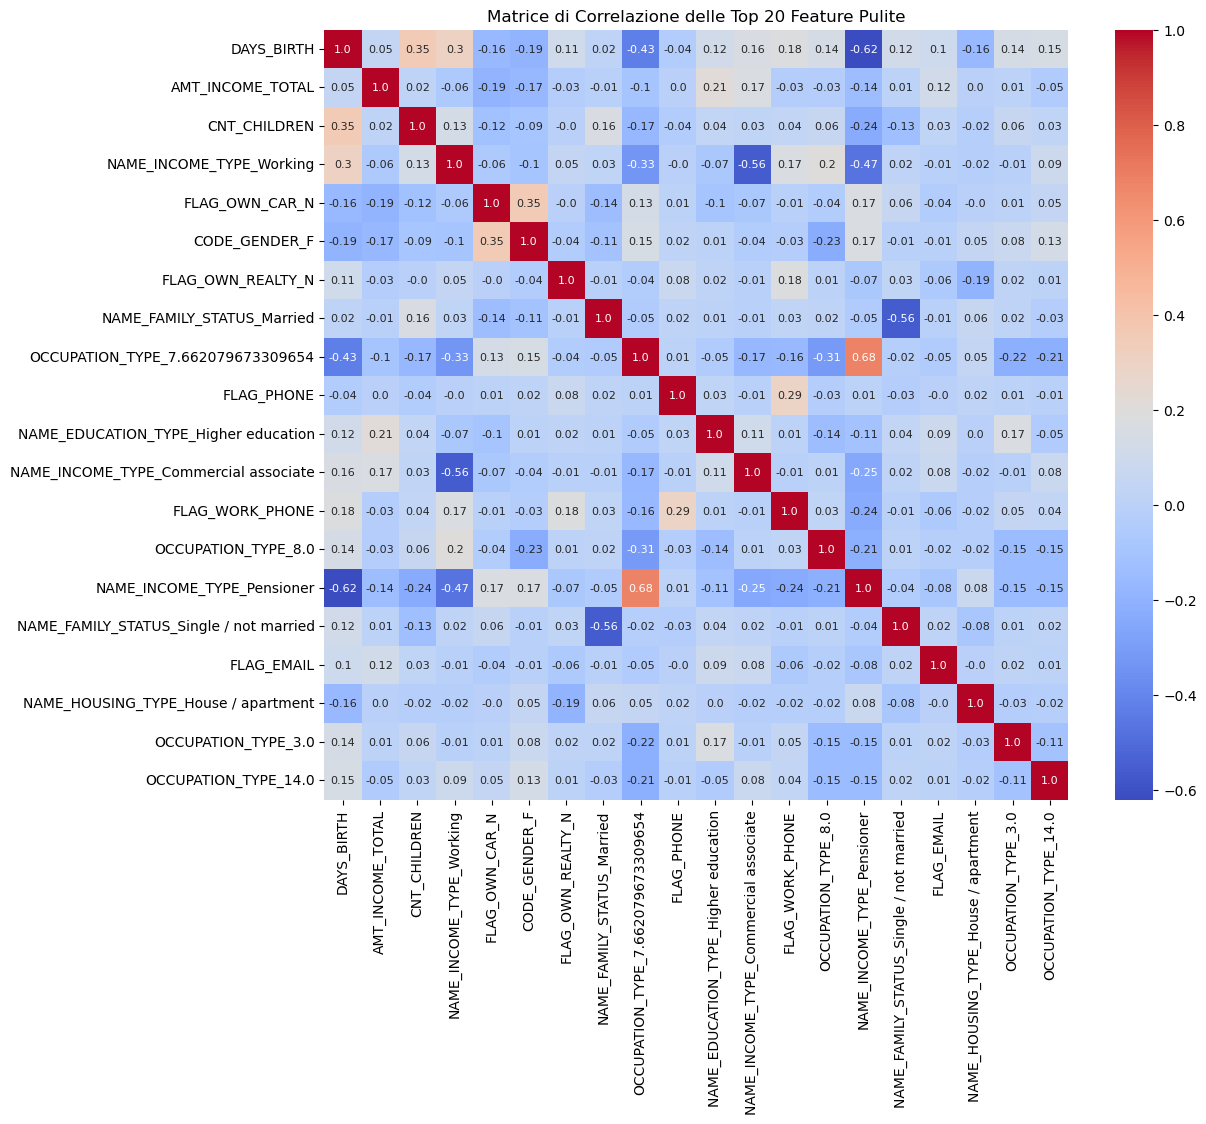

In [ ]:

correlation_matrix = df.corr().abs()


high_corr_var = np.where(correlation_matrix > 0.8)
high_corr_var = [(correlation_matrix.columns[x], correlation_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]


to_drop = set()
for (feature1, feature2) in high_corr_var:
    to_drop.add(feature2)


cleaned_features_df = df.drop(columns=to_drop)


top_20_features = cleaned_features_df.var().nlargest(20).index


final_correlation_matrix = cleaned_features_df[top_20_features].corr()


final_correlation_matrix_rounded = final_correlation_matrix.round(2)


annotations = final_correlation_matrix_rounded.astype(str)


plt.figure(figsize=(12, 10))
sns.heatmap(final_correlation_matrix_rounded, annot=annotations, fmt='', cmap='coolwarm', annot_kws={"size": 8})
plt.title('Matrice di Correlazione delle Top 20 Feature Pulite')
plt.show()

In [ ]:
num_feature = cleaned_features_df.shape[1]
print(num_feature)

50


## 2.8 model: train/test division paying attention to possible unbalancing
We observed in section 2.2 that the imbalance in the 'TARGET' feature is very strong, with a 10:1 ratio. Therefore, in the train-test split, we will add the 'stratify' argument to the train_test_split command, starting in this case from the features already filtered based on the existing correlations.

In [ ]:

X2 = cleaned_features_df.drop('TARGET', axis=1)
y2 = cleaned_features_df['TARGET']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, stratify=y2, random_state=RANDOM_SEED)

In [ ]:


y_check = pd.Series(y2)
y_train_check = pd.Series(y2_train)
y_test_check = pd.Series(y2_test)
print("Class Ratio - Original TARGET")
print(y_check.value_counts(normalize=True))
print("Class Ratio - Train")
print(y_train_check.value_counts(normalize=True))
print("Class Ratio - Test")
print(y_test_check.value_counts(normalize=True))

Class Ratio - Original TARGET
0    0.912176
1    0.087824
Name: TARGET, dtype: float64
Class Ratio - Train
0    0.912177
1    0.087823
Name: TARGET, dtype: float64
Class Ratio - Test
0    0.912172
1    0.087828
Name: TARGET, dtype: float64


# 3) BENCHMARK MODEL CREATION AND IMPROVEMENT

## 3.1 logistic regression, useful to provide easily interpretable indications
We observed a strong imbalance in the 'TARGET' variable, and therefore it would be appropriate to proceed as a first step by adding the argument 'class_weight = 'balanced'', keeping in mind that this might not be sufficient in highly imbalanced contexts.

In [ ]:
model_log_reg = LogisticRegression(class_weight='balanced', random_state=RANDOM_SEED)
model_log_reg.fit(X2_train, y2_train)


y2_pred = model_log_reg.predict(X2_test)


print("Classification Report:")
print(classification_report(y2_test, y2_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.89     92611
           1       0.30      0.88      0.45      8917

    accuracy                           0.81    101528
   macro avg       0.64      0.84      0.67    101528
weighted avg       0.93      0.81      0.85    101528



The regression provided good results in predicting negative cases, but unfortunately, it is lacking in predicting positive ones.la regressione ha dato buoni risultati sulla previsione dei casti negativi ma purtroppo risulta carente su quelli positivi

Alternative: an initial SMOTE followed by undersampling to achieve a more balanced ratio.alternativa: un preventivo SMOTE seguito da un undersampling per raggiungere un rapporto più bilanciato

## 3.2 model enhancing

In [ ]:
smote = SMOTE(sampling_strategy=0.2, random_state=RANDOM_SEED) 

X2_smote, y2_smote = smote.fit_resample(X2, y2)

In [ ]:
under_sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=RANDOM_SEED)  

X2_resampled, y2_resampled = under_sampler.fit_resample(X2_smote, y2_smote)

In [ ]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X2_resampled, y2_resampled, test_size=0.2, random_state=RANDOM_SEED)

## 3.3 model parameters check

In [ ]:
# rerun but with new balanced data
model_log_reg.fit(X3_train, y3_train)

# test set prediction
y3_pred = model_log_reg.predict(X3_test)

# model evaluation
print("Classification Report:")
print(classification_report(y3_test, y3_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84     12352
           1       0.82      0.89      0.85     12344

    accuracy                           0.85     24696
   macro avg       0.85      0.85      0.85     24696
weighted avg       0.85      0.85      0.85     24696



## The model has now a good performance, with all values above 80. 

### 3.4 Additional Point

The choice of logistic regression was made not only as a standard practice starting from a simpler model but also specifically in view of the demand for interpretability of the results. In practice, the simplest thing to explain to a potential client who was denied a credit card would be to indicate which of the considered parameters was detrimental in their specific case.

In [ ]:
# The coefficients of the logistic regression can be interpreted as the logarithm of the odds ratio, from which it is possible 
# to determine how the increase of a certain feature raises or lowers the probability of issuing the credit card.

# model coefficients
coefficients = model_log_reg.coef_[0]

#odds ration conversion
odds_ratios = np.exp(coefficients)

# dataframe visualization
feature_importance = pd.DataFrame({
    'feature': X3_train.columns,
    'coefficient': coefficients,
    'odds_ratio': odds_ratios
})

# order by importance
feature_importance = feature_importance.sort_values(by='odds_ratio', ascending=False)
print(feature_importance)

                                    feature  coefficient  odds_ratio
5            NAME_INCOME_TYPE_State servant     2.314641   10.121286
7                  NAME_INCOME_TYPE_Working     2.155456    8.631827
3     NAME_INCOME_TYPE_Commercial associate     2.130428    8.418469
24                         AMT_INCOME_TOTAL     1.091437    2.978550
6                  NAME_INCOME_TYPE_Student     1.009342    2.743795
14             NAME_FAMILY_STATUS_Separated     0.141106    1.151547
20       NAME_HOUSING_TYPE_Office apartment     0.098257    1.103246
28                               FLAG_PHONE     0.096810    1.101651
8       NAME_EDUCATION_TYPE_Academic degree     0.081576    1.084995
18      NAME_HOUSING_TYPE_House / apartment     0.074343    1.077176
29                               FLAG_EMAIL     0.035329    1.035960
0                             CODE_GENDER_F     0.022476    1.022730
10    NAME_EDUCATION_TYPE_Incomplete higher     0.000014    1.000014
2                         FLAG_OWN